# Meilleur modèle : XGBoost


## Récupérer les données nécessaires 

In [1]:
# import

import matplotlib.pyplot as plt

import numpy as np
np.random.seed(42)

import pickle

from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error, mean_absolute_error, root_mean_squared_error
from sklearn.model_selection import KFold 


In [2]:
taille_fenetre_to_run = 20
taille_stride_to_run = 5
# 20w_5s déterminer dans search window size 

In [3]:
data = pickle.load(open(f"Data/donnees_{taille_fenetre_to_run}w_{taille_stride_to_run}s.pkl", "rb"))

In [4]:
data.keys()

dict_keys(['X_np_label', 'X_np_binary', 'y_np', 'features_names_label', 'features_names_binary', 'idx_explicabilite', 'X_label_explicabilite', 'X_binary_explicabilite', 'y_explicabilite'])

In [5]:
X_np_label = data["X_np_label"]
y_np = data["y_np"]

In [6]:
X_label_explicabilite = data["X_label_explicabilite"]
y_explicabilite = data["y_explicabilite"]

In [7]:
features_label = data["features_names_label"]

In [8]:
X_np_label.shape

(19010, 152)

In [9]:
best_fold = 0
# récupérer dans notebook 5_xgboost

In [10]:
xgb_best = pickle.load(open(f'Models/XGBoost_{taille_fenetre_to_run}_fold_{best_fold}.sav', 'rb'))

## Exploration dans l'explicabilité

In [11]:
# extraire les features les plus importantes
importances = xgb_best.feature_importances_
indices = np.argsort(importances)[::-1]

# Print the top 10 feature ranking
print("Feature ranking:")
for f in range(10):
    print(f"{f+1}. {features_label[indices[f]]} ({importances[indices[f]]})")

Feature ranking:
1. QC_20 (0.663472056388855)
2. pulse_width (0.1249132975935936)
3. QC_19 (0.1107892319560051)
4. after_discharging_rest (0.03708828613162041)
5. QC_18 (0.023017795756459236)
6. cycle_to_x% (0.006016927305608988)
7. chargetime_20 (0.004682956263422966)
8. cycle_normalized_1 (0.0035937586799263954)
9. chargetime_19 (0.0017507510492578149)
10. C2 (0.0017422523815184832)


In [12]:
features_label_dict = {i: features_label[i] for i in range(len(features_label))}

# save mappage dans un fichier
with open(f"Data/XGBoost_fmap.txt", "wb") as f:
    for feature, name in features_label_dict.items():
        f.write(f"{feature}\t{name}\tq\n".encode())

<Figure size 1000x1000 with 0 Axes>

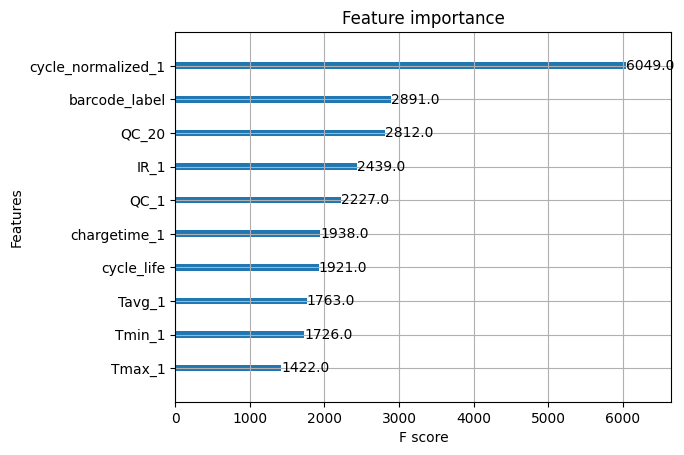

In [13]:
from xgboost import plot_importance

# Calculer l'importance des features
importances = xgb_best.get_booster().get_score(importance_type='weight')

# Visualiser l'importance des features
plt.figure(figsize=(10, 10))
plot_importance(xgb_best, importance_type='weight', max_num_features=10, fmap='Data/XGBoost_fmap.txt')

# save
plt.savefig(f"Images/XGBoost_features_importance_weight")
plt.show()


<Figure size 1000x1000 with 0 Axes>

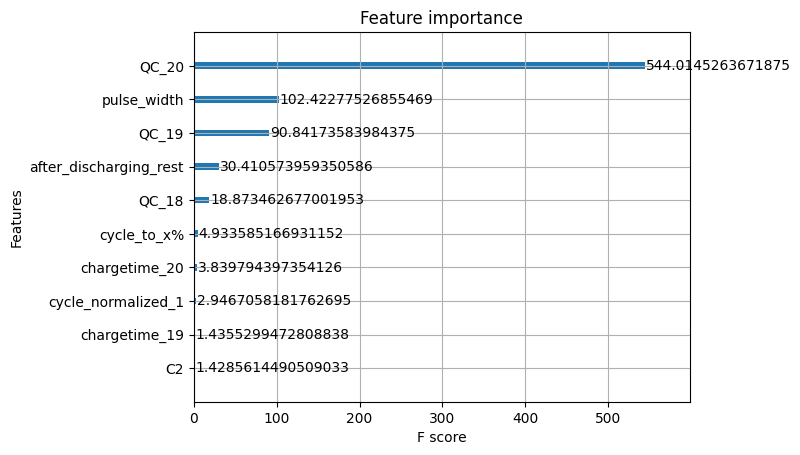

In [14]:
# importance en terme de gain cette fois ci 
importances = xgb_best.get_booster().get_score(importance_type='gain')

# Visualiser l'importance des features
plt.figure(figsize=(10, 10))
plot_importance(xgb_best, importance_type='gain', max_num_features=10, fmap='Data/XGBoost_fmap.txt')

# save
plt.savefig(f"Images/XGBoost_features_importance_gain")
plt.show()

<Figure size 1000x1000 with 0 Axes>

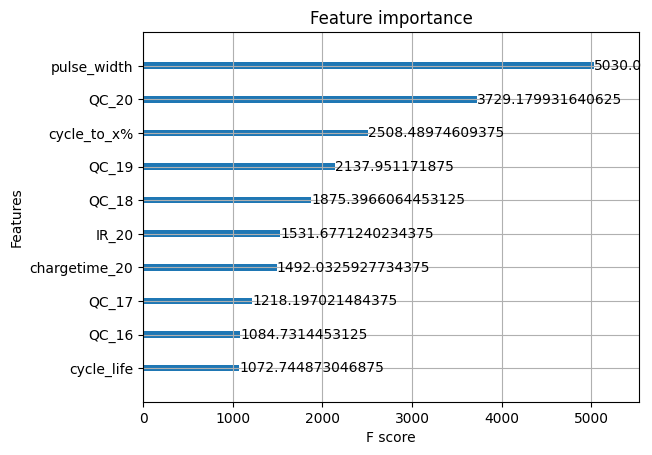

In [15]:
# idem pour la couverture
importances = xgb_best.get_booster().get_score(importance_type='cover')

# Visualiser l'importance des features
plt.figure(figsize=(10, 10))
plot_importance(xgb_best, importance_type='cover', max_num_features=10, fmap='Data/XGBoost_fmap.txt')

# save
plt.savefig(f"Images/XGBoost_features_importance_cover")
plt.show()

## Visualisation des Arbres

In [16]:
print(xgb_best.get_booster().get_dump()[0])  # Premier arbre


0:[f135<0.627521217] yes=1,no=2,missing=1
	1:[f128<0.426770866] yes=3,no=4,missing=3
		3:leaf=8.32301521
		4:leaf=8.95913219
	2:[f135<0.783626914] yes=5,no=6,missing=5
		5:leaf=9.50820637
		6:leaf=9.87608719



<Figure size 5000x1000 with 0 Axes>

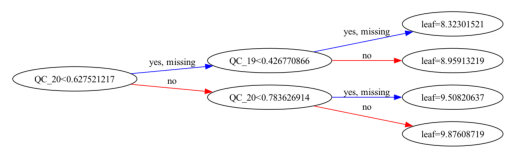

In [17]:
# Visualiser un arbre 
from xgboost import plot_tree

plt.figure(figsize=(50, 10))
# plot_tree(xgb_best, num_trees=0, rankdir='LR')
plot_tree(xgb_best, num_trees=0, fmap='Data/XGBoost_fmap.txt', rankdir='LR')
plt.savefig("Images/XGBoost_tree_0.png")
plt.show()

<Figure size 5000x1000 with 0 Axes>

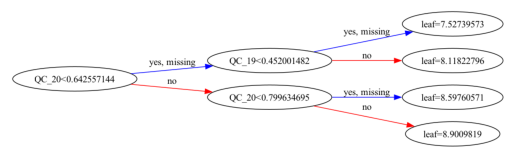

<Figure size 5000x1000 with 0 Axes>

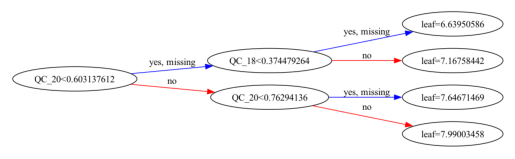

In [18]:
# Visualiser les arbres suivants
plt.figure(figsize=(50, 10))
plot_tree(xgb_best, num_trees=1, fmap='Data/XGBoost_fmap.txt', rankdir='LR')
plt.savefig("Images/XGBoost_tree_1.png")
plt.show()

plt.figure(figsize=(50, 10))
plot_tree(xgb_best, num_trees=2, fmap='Data/XGBoost_fmap.txt', rankdir='LR')
plt.savefig("Images/XGBoost_tree_2.png")
plt.show()

In [19]:
# xgb_best.best_iteration : dans un modèle XGBoost 
# fait référence à l'itération (ou arbre) qui a donné la meilleure 
# performance durant l'entraînement, selon une mesure d'évaluation spécifique 

<Figure size 5000x5000 with 0 Axes>

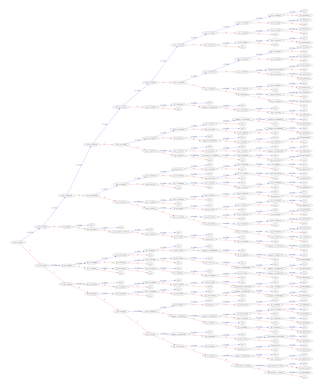

In [20]:
# Visualiser l'arbre qui a donné la meilleure performance
plt.figure(figsize=(50, 50))
plot_tree(xgb_best, num_trees=xgb_best.best_iteration, fmap='Data/XGBoost_fmap.txt', rankdir='LR')
plt.savefig("Images/XGBoost_best_tree.png", dpi=1500)
plt.show()

## Examiner les erreurs de prédiction

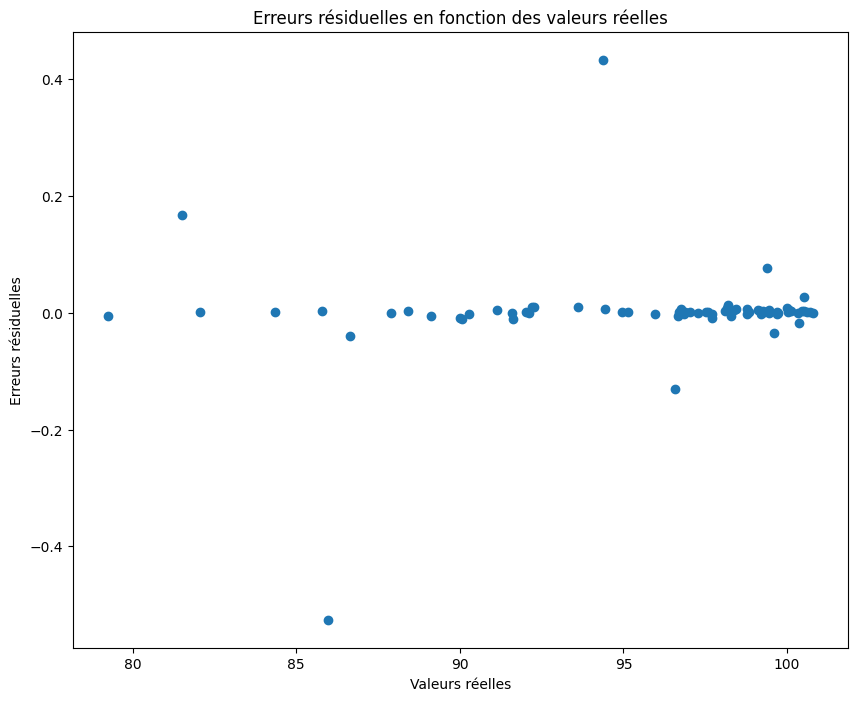

In [21]:
# Calculer les erreurs résiduelles
y_pred = xgb_best.predict(X_label_explicabilite)
errors = y_pred - y_explicabilite

# Visualisation des erreurs résiduelles
plt.figure(figsize=(10, 8))
plt.scatter(y_explicabilite, errors)
plt.xlabel('Valeurs réelles')
plt.ylabel('Erreurs résiduelles')
plt.title('Erreurs résiduelles en fonction des valeurs réelles')

# save
plt.savefig("Images/XGBoost_residuals")

plt.show()


## SHAP 

In [22]:
import shap

/Users/zoemarquis/Documents/projet_industrie/projet_batteries/mon_venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [23]:
# Calculer les valeurs de shap pour les exemples de test de l'explicabilité

explainer = shap.TreeExplainer(xgb_best) # TreeExplainer ?
shap_values = explainer(X_label_explicabilite)

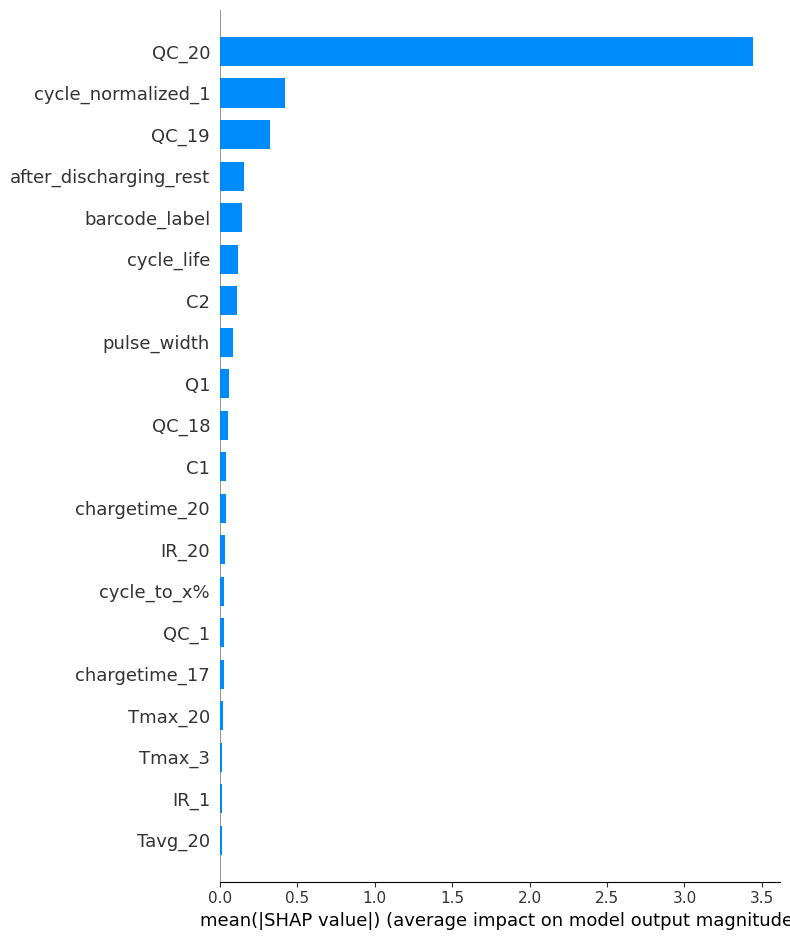

In [24]:
shap.summary_plot(shap_values, X_label_explicabilite, plot_type="bar", feature_names=features_label, show=False)
# save the plot
plt.savefig("Images/XGB_shap_summary_plot.png")
plt.show()

In [25]:
# Visualisation locale pour un exemple particulier
shap.initjs()  
# batch 1 de 0 à 23 inclus, 2 de 24 à 48 inclus, 3 de 49 à 72 inclus

# batch_1 = X_label_explicabilite[0:24]
# batch_2 = X_label_explicabilite[24:48]
# batch_3 = X_label_explicabilite[49:73]

random_idx_batch1 = np.random.randint(0, 24)
random_idx_batch2 = np.random.randint(24, 49)
random_idx_batch3 = np.random.randint(49, 73)

In [26]:
print(f"Random index batch 1: {random_idx_batch1}")
shap.force_plot(shap_values[random_idx_batch1], X_label_explicabilite[random_idx_batch1], feature_names=features_label, show=True)

# TODO debug ça s'affiche plus 
# save
plt.savefig("Images/XGB_shap_force_plot_batch1.png")
plt.show()

Random index batch 1: 6


<Figure size 640x480 with 0 Axes>

In [27]:
print(f"Random index batch 2: {random_idx_batch2}")
shap.force_plot(shap_values[random_idx_batch2], X_label_explicabilite[random_idx_batch2], feature_names=features_label)

# save
plt.savefig("Images/XGB_shap_force_plot_batch2.png")

Random index batch 2: 43


<Figure size 640x480 with 0 Axes>

In [28]:
print(f"Random index batch 3: {random_idx_batch3}")
shap.force_plot(shap_values[random_idx_batch3], X_label_explicabilite[random_idx_batch3], feature_names=features_label)

# save
plt.savefig("Images/XGB_shap_force_plot_batch3.png")

Random index batch 3: 63


<Figure size 640x480 with 0 Axes>

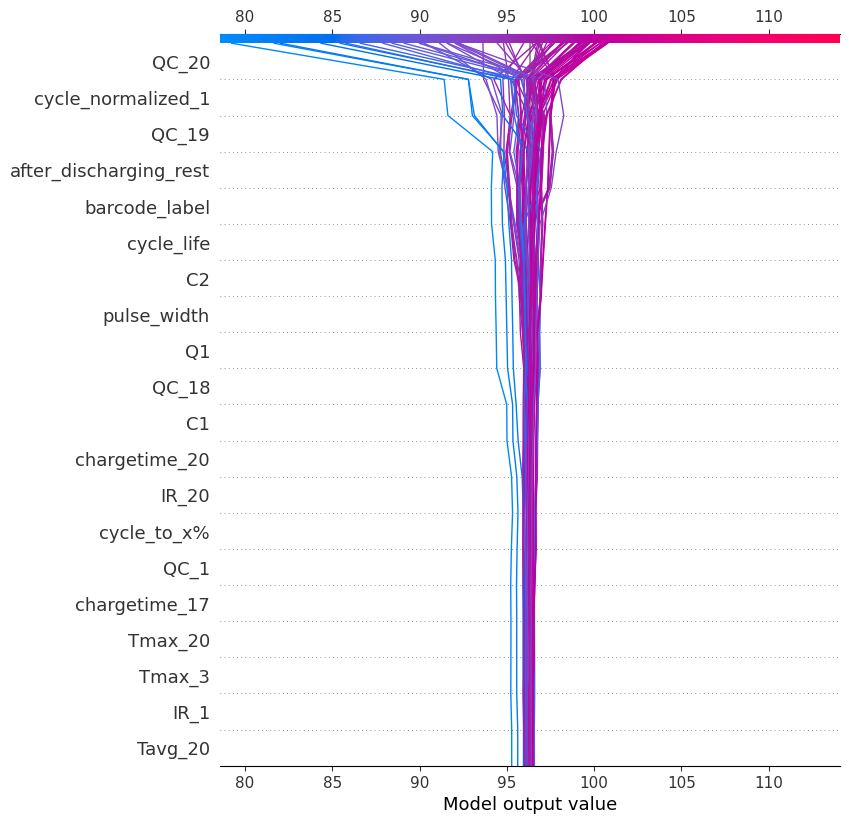

In [29]:
# Decision plot 
shap.decision_plot(explainer.expected_value, explainer.shap_values(X_label_explicabilite), X_label_explicabilite, feature_names=features_label, link='identity')

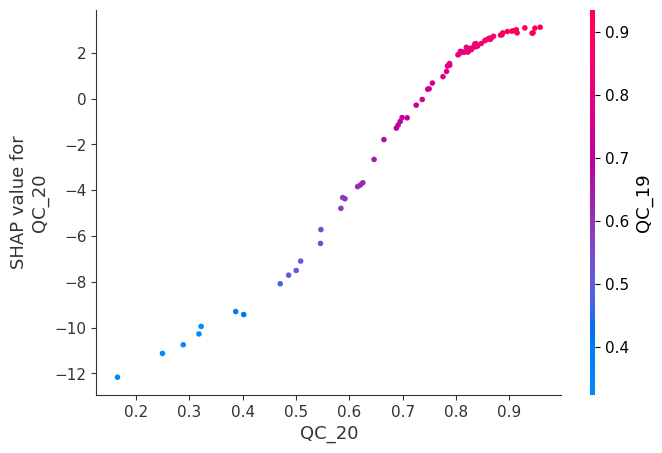

In [30]:
# Visualisation des interactions entre les features 
shap.dependence_plot("QC_20", shap_values.values, X_label_explicabilite, feature_names=features_label, show=False)

# save
plt.savefig("Images/XGB_shap_dependence_plot_QC_20.png")
plt.show()

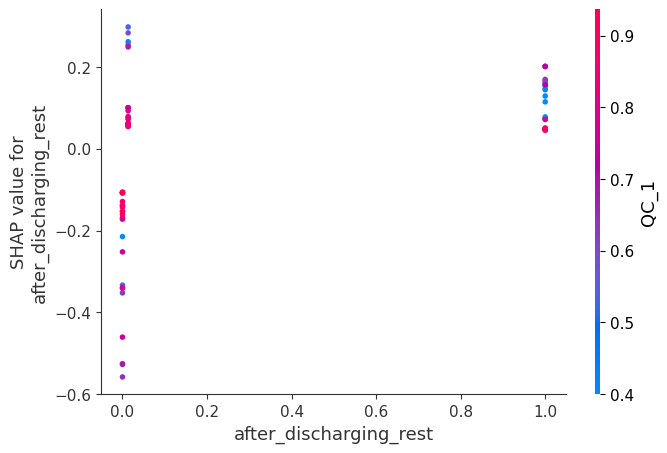

In [31]:
# Visualisation des interactions entre les features 
shap.dependence_plot("after_discharging_rest", shap_values.values, X_label_explicabilite, feature_names=features_label, show=False)

# save 
plt.savefig("Images/XGB_shap_dependence_plot_after_discharging_rest.png")
plt.show()

## LIME 

In [32]:
# from lime.lime_tabular import LimeTabularExplainer

# # TODO 
# explainer = LimeTabularExplainer(X_label_explicabilite, mode="regression", feature_names=features_label)

ModuleNotFoundError: No module named 'lime'

In [ ]:
# # expliquer une prédiction loale : batch 1 random_idx_batch1
# exp = explainer.explain_instance(X_label_explicabilite[random_idx_batch1], xgb_best.predict, num_features=10)
# exp.show_in_notebook(show_table=True)